## SKIN LESION CLASSIFICATION WITH DEEP LEARNING
MAIA 2021 -2023


*   BORRAS LLUIS
*   CISNEROS JUAN
*   LEON SOFIA

# In  Brief

The goal of this analysis is to train and test different deep learning algorithms to accurately classify skin lesions from ISIC-2017 challenge Datasets.

In [ ]:
# remove these lines if not running on notebooks
#%matplotlib notebook
run_from_notebook = False

## Import the required packages

In [1]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import glob
import cv2
from torch import optim, Tensor
from torch.utils.data import DataLoader, random_split, Dataset
from collections import OrderedDict
from sklearn.metrics import balanced_accuracy_score

## Hyperparameters and options
Hyperparameters settings to compare between experiments. Switch between pretrained true or false and options to work with and without GPU together with colab_failsafe to reload experiments at their saved checkpoint if Google Colab fails.


In [2]:
# hyperparameters
batch_size = 8
batch_size_val = 10
learning_rate = .00001
epochs = 100
momentum = 0
lr_steps = [100]   # if lr_steps[1] < epochs, we are using the MultiStepScheduler for decaying learning rate
lr_gamma = 0.1
data_augmentation = True
num_classes=3
# Define class weights for criterion
class_weights= torch.tensor([1-(1372/2000),	1-(374/2000),	1-(254/2000)], dtype=torch.float, device='cuda:0'if torch.cuda.is_available() else "cpu")
# increase the weight for minority classes, so that their loss also increases and forces the model to learn these samples.

#Flags
colab_failsafe = False    
monitor_display = True      # whether to display monitored performance plots
pretrained = True          # whether to test a pretrained model (to be loaded) or train a new one
segmented_input = True     #whether to segment the lesion to train the network 

# make visible only one GPU at the time
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  
device = "cuda:0" if torch.cuda.is_available() else "cpu" 
num_workers = int(os.cpu_count())                # how many workers (=threads) for fetching data
# Check number of workers and device
print(num_workers)
print(device)

16
cpu


## Define the model architecture
Definition of a function to choose the architecture that will be used for training. It is possible to choose between the ResNet18, DenseNet161 and ConvNeXt small, it is also possible to set the number of output classes that will be required for the task (in our case num_classes=3), it is also possible to choose to freeze some layers to only do fine tuning in the higher layers. It also sets the resize parameter of the images.

In [4]:
def initialize_model(model_name, num_classes, use_pretrained=True, freeze=False):
    # Initialize these variables which will be set in this if statement. Each of these
    # variables is model specific.
    net = None
    resize_param = 0
    if model_name=="convnext":
      """ ConvNeXt small
        """
      net = models.convnext_small(pretrained=use_pretrained)
      num_ftrs = net.classifier[2].in_features
      net.classifier[2] = nn.Linear(num_ftrs,3)
      if freeze:
        for param in net.features[:-2].parameters():
          param.requires_grad = False
      resize_param = 224

    elif model_name == "resnet":
      """ ResNet 18
        """
      net = models.resnet18(pretrained=True)
      num_ftrs = net.fc.in_features
      net.fc = nn.Linear(num_ftrs, num_classes)
      resize_param = 224

    elif model_name == "densenet":
        """ DenseNet 161
        """
        net = models.densenet161(pretrained=use_pretrained)
        num_ftrs = net.classifier.in_features
        net.classifier = nn.Linear(num_ftrs, num_classes)
        if freeze:
          for param in net.features[:-5].parameters():
            param.requires_grad = False
        resize_param = 224
        
    else:
        print("Invalid model name, exiting...")
        exit()

    return net, resize_param


# Initialize the model for this run
net, resize_param = initialize_model("convnext", 3, use_pretrained=True)

# Print the model we just instantiated
print(net)

#Test to check if selected network is giving the number of desired outputs
im=torch.randn(1,3,224,224)
out=net(im)
print(out)

/home/sofileon/miniconda3/envs/ssl_sofi/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sofileon/miniconda3/envs/ssl_sofi/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Small_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to /home/sofileon/.cache/torch/hub/checkpoints/convnext_small-0c510722.pth


  0%|          | 0.00/192M [00:00<?, ?B/s]

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

## Create the building blocks for training
Create the loss function, the optimizer, and learning rate scheduler.  Associate an experiment_ID to save the result of the training of the network.

In [5]:
# create loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

# create SGD optimizer
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

# create learning rate scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_steps, gamma=lr_gamma)

# experiment ID
experiment_ID = "%s_%s_%s_%s_bs(%d)lr(%.6f_%.1f)m(%.1f)epochs(%d)da(%s)BN_Normalize" % (type(net).__name__, type(criterion).__name__, type(optimizer).__name__, type(scheduler).__name__,
                 batch_size, learning_rate, lr_gamma, momentum, epochs, data_augmentation)
print(experiment_ID)

## Create datasets
A custom image dataset class was created following Pytorch guidelines to load and process/augment our image Dataset, definintion of init, len, and getitem functions of the class. Definiton of my_collate that will be used the dataloader and show_image_batch to show batches after transformations.

In [ ]:
# create datasets, transforms will be set after (or can be set here, if we had all we need)
# NOTE: torchvision MNIST has no validation set, we will use the test set as validation set
#       but in a real case scenario we MUST use a train / validation / test split to avoid
#       introducing biases in our results (final model performance SHOULD NOT be evaluated
#       on the validation set)
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, mask_dir,img_dir, prediction_s=True, transform=None, mask_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.mask_dir = mask_dir
        self.img_dir = img_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.prediction_state=prediction_s

    def __len__(self): #check the size of the dataset
        return len(self.img_labels)

    def __getitem__(self, idx): #read one image
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0] + '.jpg')
        if self.prediction_state:
          mask_path = os.path.join(self.mask_dir, self.img_labels.iloc[idx, 0] + '_prediction.png')
        else:
           mask_path = os.path.join(self.mask_dir, self.img_labels.iloc[idx, 0] + '_segmentation.png')
        image = read_image(img_path)
        mask= read_image(mask_path)
        label = self.img_labels.iloc[idx, 4]
        seed = np.random.randint(651998) # make a seed with numpy generator 
        if self.transform:
            torch.manual_seed(seed) 
            image = self.transform(image)
        if self.mask_transform:
            torch.manual_seed(seed)
            mask = self.mask_transform(mask)
        return image,mask, label


def my_collate(batch):
    data = [item[0] for item in batch]
    data_mask = [item[1] for item in batch]
    target = [item[2] for item in batch]
    target =torch.tensor(target)
    data_mask = torch.stack(data_mask, dim=0)
    data = torch.stack(data, dim=0)
    return [data, data_mask, target]


def show_image_batch(img_list):
    num = len(img_list)
    fig = plt.figure(figsize=(20,20))
    for i in range(num):
        ax = fig.add_subplot(1, num, i+1)
        img=img_list[i].numpy().transpose([1,2,0])
        ax.imshow(img/255)
    plt.show()

Loading the ISIC training, validation and testing datasets as CustomDatasets objects to be called in their own Dataloader for training and testing phases.

In [ ]:
# let's load our google drive
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# Dataset train
dir_train = '/content/drive/MyDrive/ISIC-2017_Training_Data/'
dir_mask = '/content/drive/MyDrive/predictions_train'
annotations_file_train = '/content/drive/MyDrive/ISIC-2017_Training_Mask/ISIC-2017_Training_Part3_GroundTruth.csv'
dataset_train = CustomImageDataset(img_dir=dir_train,mask_dir=dir_mask,annotations_file=annotations_file_train)

# Dataset validation
dir_validation = '/content/drive/MyDrive/ISIC-2017_Validation_Data/'
mask_valid ='/content/drive/MyDrive/predictions_valid'
annotations_file_validation = '/content/drive/MyDrive/ISIC-2017_Validation_Part1_GroundTruth/ISIC-2017_Validation_Part3_GroundTruth.csv'
dataset_valid = CustomImageDataset(img_dir=dir_validation, mask_dir=mask_valid, annotations_file=annotations_file_validation)

#Dataset test
dir_test_images = '/content/drive/MyDrive/ISIC-2017_Test_v2_Data/'
dir_test_masks = '/content/drive/MyDrive/predictions_test'
annotations_file_test = '/content/drive/MyDrive/ISIC-2017_Test_v2_Part1_GroundTruth/ISIC-2017_Test_v2_Part3_GroundTruth.csv'
dataset_test = CustomImageDataset(img_dir=dir_test_images, mask_dir = dir_test_masks, annotations_file=annotations_file_test)


print ("\nTrain data are %d images" % (len(dataset_train)))
print ("\nValidation data are %d images" % (len(dataset_valid)))
print ("\nTest data are %d images" % (len(dataset_test)))

Mounted at /content/drive

Train data are 2000 images

Validation data are 150 images

Test data are 600 images


## Define data transforms

A series of data transformations are defined. First a Convert Class will convert the data to a float tensor once called.
We compose the following transformations: Convert is called, then resizing of the images to a resize_param defined when calling the function _initialize_model_, and then standarization of the data with the means (mu) and standard deviation (std) that were calculated by averaging these statistics in the whole training, validation and test set separately. 
If Data augmentation is chosen it will perform random rotations, vertical and horizontal flips, affine trasnformations (scaling, transposing and shearing) and perspective rotations with a probability occurance of 0.3. 
Data augmentation is only applied on the training set.

In [ ]:
# Mean and Standard deviation were calculated outside of collab per channel
# Train set statistics
mu_train_r=180.514
mu_train_b=139.454
mu_train_g=150.850
std_train_r=35.242
std_train_b=35.249
std_train_g=35.250

# Validation Set statistics
mu_val_r=176.615
mu_val_b=130.143
mu_val_g=142.922
std_val_r=34.276
std_val_b=34.287
std_val_g=34.319

# Test Set statistics
mu_test_r=181.740
mu_test_b=129.762
mu_test_g=140.271
std_test_r=38.435
std_test_b=38.439
std_test_g=38.438

# define Convert transform to convert CIFAR10 images to torch float tensors
# the operations are (in sequence):
# - 'np.array' to convert the image to a numpy array
# - 'torch.from_numpy' to convert the numpy array to torch tensor
# - '.float()' to convert to float tensors, since deep learning builds on float numbers
class Convert(object):
  def __call__(self, img):
       return torch.from_numpy(np.array(img)).float()


DataAugmentation = transforms.RandomApply(torch.nn.ModuleList([transforms.RandomRotation(50), 
                                                               transforms.RandomVerticalFlip(), 
                                                               transforms.RandomHorizontalFlip(),
                                                               transforms.RandomAffine(degrees=0, scale=(.9, 1.1), translate=(0.2, 0.2), shear=30),
                                                               transforms.RandomPerspective(distortion_scale=0.3)]), p=0.3)

#Composing of transformations for each dataset
# define data transform as a composition of Data Augmentation (training only), Convert, Normalize, and Reshape
# Normalize implements standardization using the previously computed mu and std
transform_train_augmentation = transforms.Compose([DataAugmentation,Convert(),transforms.Resize(size = (resize_param,resize_param)), 
                                                   transforms.Normalize(mean=[mu_train_r, mu_train_g, mu_train_b], std=[std_train_r, std_train_g, std_train_b])])
transform_train = transforms.Compose([Convert(),transforms.Resize(size = (resize_param,resize_param)),
                                      transforms.Normalize(mean=[mu_train_r, mu_train_g, mu_train_b], std=[std_train_r, std_train_g, std_train_b])])

transform_mask_augmentation = transforms.Compose([DataAugmentation,Convert(), transforms.Resize(size = (resize_param, resize_param))])
transform_mask = transforms.Compose([Convert(), transforms.Resize(size = (resize_param, resize_param))])

transform_valid = transforms.Compose([Convert(),transforms.Resize(size = (resize_param,resize_param)),transforms.Normalize(mean=[mu_val_r, mu_val_g, mu_val_b],
                                                                      std=[std_val_r, std_val_g, std_val_b])])

transform_test = transforms.Compose([Convert(),transforms.Resize(size = (resize_param,resize_param)),transforms.Normalize(mean=[mu_test_r, mu_test_g, mu_test_b],
                                                                      std=[std_test_r, std_test_g, std_test_b])])


# set data and mask transforms on both datasets, data augmentation is only done in the train dataset
if data_augmentation:
  dataset_train.transform = transform_train_augmentation
  dataset_train.mask_transform = transform_mask_augmentation
else:
  dataset_train.transform = transform_train
  dataset_train.mask_transform = transform_mask

dataset_valid.transform = transform_valid
dataset_valid.mask_transform = transform_mask
dataset_test.transform = transform_test
dataset_test.mask_transform = transform_mask

## Create data loaders
Dataloaders are in-built PyTorch objects that serve to sample batches from datasets. The train dataloader fetches the images for the batches randomly with a specific batch size and with the help of my_collate function. On the other hand, the dataloaders for validation and test fetch the images for the batches without shuffling with the help of my_collate function

In [ ]:
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, collate_fn=my_collate)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size_val, num_workers=num_workers, pin_memory=True, collate_fn=my_collate)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size_val, num_workers=num_workers, pin_memory=True, collate_fn=my_collate)

## Check the data _after_ transforms are applied
To check what the network will see at train/test time after transformations are applied.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


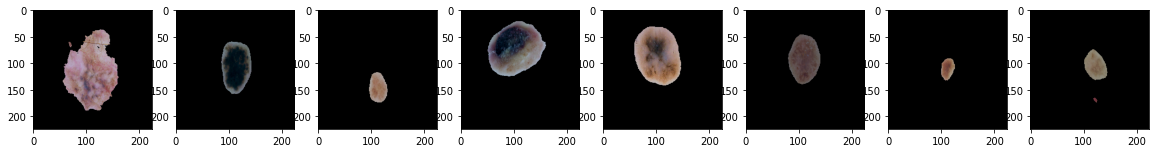

In [ ]:
for i, minibatch in enumerate(dataloader_train):
  if i >= 1:
    break
  data, masks, labels = minibatch 
  data=data*std_train_b + mu_train_b 
  if segmented_input:
    t=[]
    for im,m in zip(data,masks):
      m[m > 0] = 1
      masked = im*m
      t.append(masked)
    t=torch.stack(t,dim=0)
    show_image_batch(t)
  else:
    show_image_batch(data)

## Define train function
Creation of the train function that will be call at each epoch during training. Returns the average loss per epoch, the accuracy and the balanced multiclass accuracy.

In [ ]:
# define train function (1 epoch)
def train(dataset, dataloader):

    # switch to train mode
    net.train()
    # reset performance measures
    loss_sum = 0.0
    correct = 0
    sample_counter = 0
    all_outputs = torch.zeros((len(dataset),1), dtype=torch.int64)
    all_targets = torch.zeros((len(dataset),1), dtype=torch.int64)
    # 1 epoch = 1 complete loop over the dataset
    for batch in dataloader:

        # get data from dataloader
        images, masks, targets= batch
        
        # segment lesions if needed
        if segmented_input:
          inputs=[]
          for image, mask in zip(images, masks):
            mask[mask > 0] = 1
            masked_image = image*mask
            inputs.append(masked_image)
          inputs=torch.stack(inputs,dim=0)
        else:
          inputs=images

        # move data to device
        inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = net(inputs)
        
        # calculate loss
        loss = criterion(outputs, targets)

        # loss gradient backpropagation
        loss.backward()

        # net parameters update
        optimizer.step()

        # accumulate loss
        loss_sum += loss.item()

        # accumulate correct outputs (for accuracy calculation) 
        outputs_max = torch.argmax(outputs, dim=1)
        batch_correct=torch.sum(targets==outputs_max)
        correct += batch_correct

        # accumulate outputs and target (for BMA calculation) 
        for output, target in zip(outputs_max,targets):
                all_outputs[sample_counter] = output
                all_targets[sample_counter] = target
                sample_counter += 1
    # step learning rate scheduler once training all batches is done
    scheduler.step()
    BM_Accuracy= balanced_accuracy_score(all_targets.cpu().detach().numpy(), all_outputs.cpu().detach().numpy())
    # return average loss and accuracy
    return loss_sum / len(dataloader), 100. * correct / len(dataset), 100*BM_Accuracy

## Define test function
To be called during training for validation at each epoch, or after training for testing. It returns the true labels and the predicted labels.

In [ ]:
# define test function
# returns predictions
def test(dataset, dataloader):

    # switch to test mode
    net.eval()  

    # initialize predictions
    predictions = torch.zeros((len(dataset),1), dtype=torch.int64)
    labels = torch.zeros((len(dataset),1), dtype=torch.int64)
    sample_counter = 0
    # do not accumulate gradients (faster)
    with torch.no_grad():

        # test all batches
        for batch in dataloader:

            # get data from dataloader 
            images, masks, targets= batch

            # segment lesions if needed
            if segmented_input:
              inputs=[]
              for image, mask in zip(images, masks):
                mask[mask > 0] = 1
                masked_image = image*mask
                inputs.append(masked_image)
              inputs=torch.stack(inputs,dim=0)
            else:
              inputs=images   

            # move data to device
            inputs = inputs.to(device, non_blocking=True)

            # obtain predictions
            outputs = net(inputs)

            # store predictions
            outputs_max = torch.argmax(outputs, dim=1)
            for output, target in zip(outputs_max,targets):
                predictions[sample_counter] = output
                labels[sample_counter]= target
                sample_counter+=1

    return predictions,labels

If Google Colab fails reload experiment up until last best performing result in validation to continue running

In [ ]:
if colab_failsafe:
    path = "/content/drive/MyDrive/train_networks/DL_Classification/"

    experiment_ID_load = "ConvNeXt_CrossEntropyLoss_SGD_batchsize(8)lr(0.000010_1000_0.1)m(0.45)epochs(100)da(True)BN_Normalize_segmented"
    checkpoint = torch.load(path + experiment_ID_load + ".tar", map_location=lambda storage, loc: storage)
    epochs_net = checkpoint['epoch']
    BMA_net = checkpoint['accuracy']
    BMAtrain_net = checkpoint['accuracy_train']
    net.load_state_dict(checkpoint['net_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss_net = checkpoint['loss']
    print('loaded...')

## Train a new model or test a pretrained one
The code below also includes visual loss/BMA monitoring during training, both on training and validation sets. 

Loaded pretrained model
... validation reached accuracy 65.95% at epoch 93


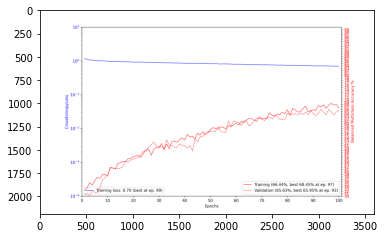

Test BMA:68.09% 
Test Accuracy: 66.83% 


In [ ]:
# pretrained model not available --> TRAIN a new one and save it
# to save and load model
path = "/content/drive/MyDrive/SkinLesionsSegmentationClassificationMaterial/DeepLearning_Classification/"
graph_path="/content/drive/MyDrive/SkinLesionsSegmentationClassificationMaterial/DeepLearning_Classification/"

if not pretrained:
    epoch_time=[]
    if not colab_failsafe:
      # reset performance monitors
      losses = []
      train_BMA= []
      valid_BMA=[]
      valid_accuracies = []
      train_accuracies = []
      ticks = []
      start=1
      epoch_time=[]

    else:
      losses = loss_net
      train_BMA = BMAtrain_net
      valid_BMA = BMA_net
      ticks = epochs_net
      train_accuracies = []
      valid_accuracies = []
      start=max(ticks)+1

    
    # move net to device
    net.to(device)

    
    # start training
    for epoch in range(start, epochs+1):

        # measure time elapsed
        t0 = time.time()
        
        #train
        avg_loss, accuracy_train, BMA_train = train(dataset_train, dataloader_train)

        # test on validation
        predictions,labels_valid = test(dataset_valid, dataloader_valid)
        accuracy_valid = 100. * (predictions == labels_valid).sum().float()/ len(dataset_valid)
        BMA_valid=100*balanced_accuracy_score(labels_valid.cpu().detach().numpy(), predictions.cpu().detach().numpy())
                    
        # update performance history
        losses.append(avg_loss)
        train_accuracies.append(accuracy_train.cpu())
        train_BMA.append(BMA_train)
        valid_accuracies.append(accuracy_valid.cpu())
        valid_BMA.append(BMA_valid)
        ticks.append(epoch)
        epoch_time.append(time.time()-t0)

        # print or display performance
        if not monitor_display:
            print ("\nEpoch %d\n"
                "...TIME: %.1f seconds\n"
                "...loss: %g (best %g at epoch %d)\n"
                "...training accuracy: %.2f%% (best %.2f%% at epoch %d)\n"
                "...validation accuracy: %.2f%% (best %.2f%% at epoch %d)" % (
                epoch,
                time.time()-t0,
                avg_loss, min(losses), ticks[np.argmin(losses)],
                BMA_train,
                max(train_BMA),
                ticks[np.argmax(train_BMA)],
                BMA_valid, max(valid_BMA), ticks[np.argmax(valid_BMA)]))
        else:
            print ("\nEpoch %d\n"
                "...TIME: %.1f seconds\n"
                "...LR:%.10f"% (
                epoch,
                time.time()-t0,
                scheduler.get_last_lr()[0]
                ))
            fig, ax1 = plt.subplots(figsize=(12, 8), num=1)
            fig.suptitle("CONVNEXT_SMALL, data augmentation, w segmentation, freezed layers, 100 epochs")
            ax1.set_xticks(np.arange(0, epochs+1, step=epochs/10.0))
            ax1.set_xlabel('Epochs')
            ax1.set_ylabel(type(criterion).__name__, color='blue')
            ax1.set_ylim(0.0001, 10)
            ax1.tick_params(axis='y', labelcolor='blue')
            ax1.set_yscale('log')
            ax1.plot(ticks, losses, 'b-', linewidth=1.0, aa=True, 
                label='Training loss: %.2f (best at ep. %d)' % (avg_loss,ticks[np.argmin(losses)]))
            ax1.legend(loc="lower left")
            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
            ax2.set_ylabel('Balanced Multiclass Accuracy %', color='red')
            ax2.set_ylim(30, 100)
            ax2.set_yticks(np.arange(30, 100, step=1))
            ax2.tick_params(axis='y', labelcolor='red')
            ax2.plot(ticks, train_BMA, 'r-', linewidth=1.0, aa=True, 
                label='Training (%.2f%%, best %.2f%% at ep. %d)' % (BMA_train, max(train_BMA), ticks[np.argmax(train_BMA)]))
            ax2.plot(ticks, valid_BMA, 'r--', linewidth=1.0, aa=True, 
                label='Validation (%.2f%%, best %.2f%% at ep. %d)' % (BMA_valid, max(valid_BMA), ticks[np.argmax(valid_BMA)]))
            ax2.legend(loc="lower right")
            plt.xlim(0, epochs+1)
            plt.savefig(graph_path+experiment_ID + ".png", dpi=300)
             # this works if running from notebooks
            if run_from_notebook:
                fig.show()
                fig.canvas.draw()
            # this works if running from console
            else:
                plt.draw()
                #plt.pause(0.001)
                plt.show()
           # plt.savefig(experiment_ID + ".png", dpi=300)
            fig.clear()

        # save model if validation performance has improved
        if (epoch-1) == np.argmax(valid_BMA):
            torch.save({
            'net_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': losses,
            'accuracy': valid_BMA,
            'accuracy_train':train_BMA,
            'epoch': ticks,
            'epoch_time_net': epoch_time
            }, path + experiment_ID + ".tar")
            print('Model saved!')
            
# pretrained = True, test the model on the test set
else:
    experiment_ID_load="ConvNext_momentum(0)_segmented images"
    # load pretrained model
    checkpoint = torch.load(path + experiment_ID_load + ".tar", map_location=lambda storage, loc: storage)
    performance_graph = plt.imread(graph_path + experiment_ID_load + "_performance.png", format=None)
    valid_BMA= checkpoint['accuracy']
    epochs_net=checkpoint['epoch']
    net.load_state_dict(checkpoint['net_state_dict'])
    loss = checkpoint['loss']
    train_BMA = checkpoint['accuracy_train']

    print ("Loaded pretrained model\n... validation reached accuracy %.2f%% at epoch %d" % (max(valid_BMA),max(epochs_net)))
    plt.imshow(performance_graph)
    plt.show()
    # move net to device
    net.to(device)

    # test
    predictions_test,labels_test = test(dataset_test, dataloader_test)

    accuracy_test = 100. * (predictions_test == labels_test).sum().float()/ len(dataset_test)
    BMA_test=100*balanced_accuracy_score(labels_test.cpu().detach().numpy(), predictions_test.cpu().detach().numpy())
    print("Test BMA:%.2f%% \n"
        "Test Accuracy: %.2f%% "% (
            BMA_test,
            accuracy_test))

In [ ]:
while True: pass